In [119]:
%pip install formulaic

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from patsy import dmatrix
from formulaic import model_matrix
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
warnings.filterwarnings("ignore")  # Ignore warnings to make output cleaner

34803.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [120]:
# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

In [121]:
# Convert 'from' column to datetime and remove timezone information
data['from'] = pd.to_datetime(data['from'])
data['from'] = data['from'].dt.tz_localize(None)  # Remove timezone info if present
data.set_index('from', inplace=True)


In [122]:
# Filter relevant columns
spot_price = data['SpotPriceDKK']
weather_columns = [col for col in data.columns if 'mean_temp' in col or 'wind' in col]
weather_data = data[weather_columns]

In [123]:
# Handle missing values
spot_price = spot_price.replace(0, np.nan).fillna(method='ffill').fillna(spot_price.mean())
weather_data.fillna(method='ffill', inplace=True)
weather_data.fillna(weather_data.mean(), inplace=True)

In [124]:
# Create cross features: wind speed and direction
wind_speed_columns = [col for col in weather_data.columns if 'wind_speed' in col]
wind_direction_columns = [col for col in weather_data.columns if 'wind_dir' in col]
cross_features = pd.DataFrame(index=weather_data.index)

for speed_col in wind_speed_columns:
    for dir_col in wind_direction_columns:
        if speed_col.split('_')[-1] == dir_col.split('_')[-1]:  # Match by suffix
            cross_features[f'{speed_col}_in_{dir_col}'] = weather_data[speed_col] * weather_data[dir_col]


In [126]:
# Add Fourier terms for hourly seasonality
hours_in_day = 24
hours_in_week = 24 * 7

hour_of_day = spot_price.index.hour
hour_of_week = (spot_price.index.dayofweek * 24) + spot_price.index.hour

x_fourier = pd.DataFrame(index=spot_price.index)
x_fourier['sin_hourly'] = np.sin(2 * pi * hour_of_day / hours_in_day)
x_fourier['cos_hourly'] = np.cos(2 * pi * hour_of_day / hours_in_day)
x_fourier['sin_weekly'] = np.sin(2 * pi * hour_of_week / hours_in_week)
x_fourier['cos_weekly'] = np.cos(2 * pi * hour_of_week / hours_in_week)
x_fourier['time_trend'] = np.arange(len(x_fourier))  # Linear trend

#sort the temperature data
temperature_columns = [col for col in weather_data.columns if 'temp' in col]
temperature_data = weather_data[temperature_columns].mean(axis=1)


# Combine features
exog_features = pd.concat([cross_features, x_fourier, temperature_data], axis=1).dropna()


In [127]:
# Define the training cutoff date
cutoff_date = '2024-08-01'

# Ensure the index is sorted
spot_price = spot_price.sort_index()
exog_features = exog_features.sort_index()

# Split the data into the training set (up to cutoff) and the rest (forecast period)
train_data = spot_price.loc[:cutoff_date]
test_data = spot_price.loc[cutoff_date:]  # Data after the cutoff for rolling forecast
exog_train = exog_features.loc[:cutoff_date]
exog_test = exog_features.loc[cutoff_date:]

# Create placeholders for results
rolling_forecast = []
rolling_dates = []

In [128]:
# Initialize the model with training data
sarimax_model = SARIMAX(
    train_data,
    exog=exog_train,
    order=(2, 0, 0),
)
sarimax_results = sarimax_model.fit(disp=False)

In [129]:
# Rolling forecast loop
current_start = train_data.index[-1] + pd.Timedelta(hours=1)

for i in range(len(test_data) // 24):  # Iterate over 24-hour chunks
    # Forecast 24 hours into the future
    forecast_steps = 24
    forecast_index = pd.date_range(start=current_start, periods=forecast_steps, freq='H')

In [130]:
  # Prepare exogenous variables for the forecast period
  future_exog = exog_test.loc[forecast_index]

  # Forecast
  forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=future_exog).predicted_mean

  # Save the forecast
  rolling_forecast.append(forecast)
  rolling_dates.extend(forecast_index)

In [131]:
 # Update model with new observed data (if available)
 if forecast_index[-1] in test_data.index:
    observed_data = test_data.loc[current_start:forecast_index[-1]]
    train_data = pd.concat([train_data, observed_data])
    exog_train = pd.concat([exog_train, future_exog.loc[observed_data.index]])

from
2024-08-01 00:00:00    648.090027
2024-08-01 01:00:00    627.640015
2024-08-01 02:00:00    642.489990
2024-08-01 03:00:00    739.500000
2024-08-01 04:00:00    852.320007
Name: SpotPriceDKK, dtype: float64
count    1926.000000
mean      532.011236
std       356.562236
min      -447.459991
25%       267.964996
50%       583.730011
75%       742.537506
max      2535.959961
Name: SpotPriceDKK, dtype: float64


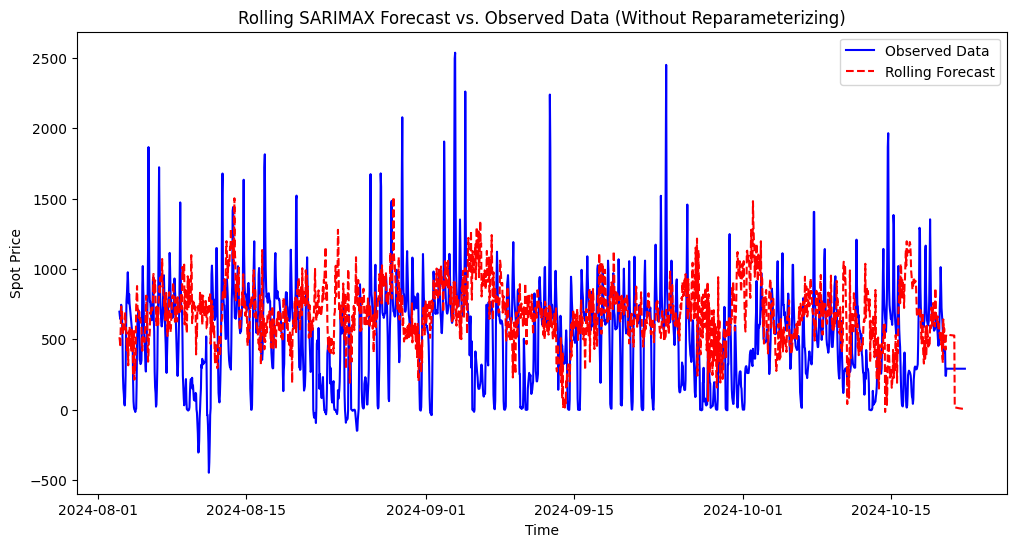

In [132]:
# Rolling forecast without reparameterizing
rolling_forecast = []
forecast_steps = 24
current_start = train_data.index[-1] + pd.Timedelta(hours=1)

print(test_data.head())
print(test_data.describe())

for i in range(len(test_data) // forecast_steps):
    # Define forecast index for the next 24 hours
    forecast_index = pd.date_range(start=current_start, periods=forecast_steps, freq='H')

    # Ensure exogenous variables align with the forecast index
    future_exog = exog_test.reindex(forecast_index).fillna(method='ffill').fillna(0)

    # Use the existing SARIMAX model to generate the forecast
    forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=future_exog).predicted_mean

    # Assign the correct index to the forecast
    forecast.index = forecast_index

    # Save the forecast
    rolling_forecast.append(forecast)

    # Update current_start for the next forecast chunk
    current_start = forecast_index[-1] + pd.Timedelta(hours=1)

# Combine all forecasts into a single series
rolling_forecast = pd.concat(rolling_forecast)

# Filter the observed data to match the forecast period
observed_data = test_data.reindex(rolling_forecast.index).fillna(method='ffill').fillna(0)

# Plot observed data and rolling forecast
plt.figure(figsize=(12, 6))
plt.plot(observed_data, label='Observed Data', color='blue')
plt.plot(rolling_forecast, label='Rolling Forecast', linestyle='--', color='red')
plt.legend()
plt.title("Rolling SARIMAX Forecast vs. Observed Data (Without Reparameterizing)")
plt.xlabel("Time")
plt.ylabel("Spot Price")
plt.show()


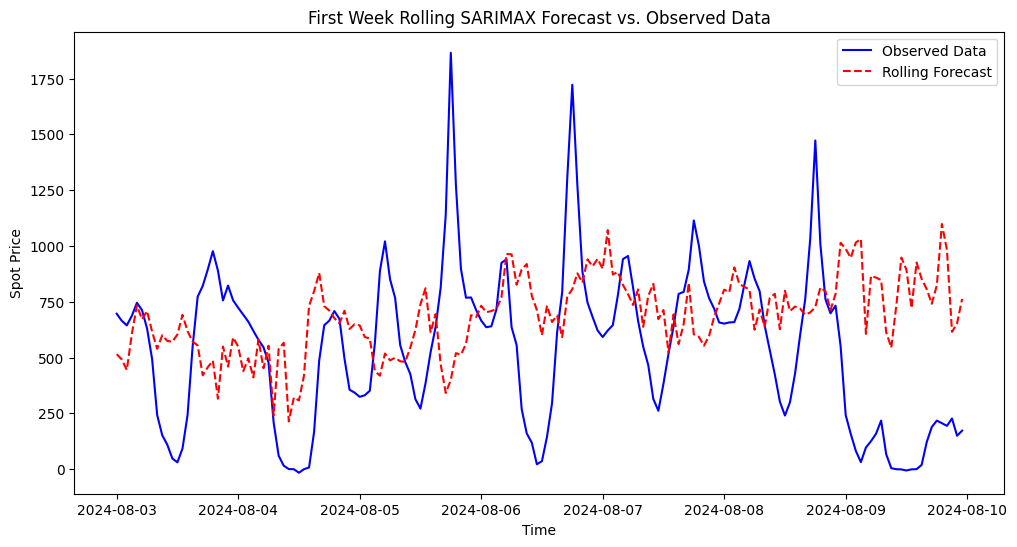

In [133]:
# Define the number of hours in a week
hours_in_week = 7 * 24

# Slice the first week of predictions and observed data
first_week_forecast = rolling_forecast[:hours_in_week]
first_week_observed = observed_data[:hours_in_week]

# Plot the first week of observed data and rolling forecast
plt.figure(figsize=(12, 6))
plt.plot(first_week_observed, label='Observed Data', color='blue')
plt.plot(first_week_forecast, label='Rolling Forecast', linestyle='--', color='red')
plt.legend()
plt.title("First Week Rolling SARIMAX Forecast vs. Observed Data")
plt.xlabel("Time")
plt.ylabel("Spot Price")
plt.show()